# Basic Ideas of Finding Regions
Detailed exploration of the method proposed in [this paper](https://proceedings.mlr.press/v221/liu23a.html) by Liu et al. but focused on a single-layer approach.

## Simulating a ReLU layer

We start by simulating a ReLU layer from $\mathbb{R}^2\to\mathbb{R}^3$. This require a $(3\times2)$ weight matrix $W$ and a $(3\times1)$ bias vector $b$:

In [369]:
import numpy as np

# Set random seed for reproducibility
# Seeds that work quite well: 45, 3
np.random.seed(3)

W = np.random.randn(3,2)
b = np.random.randn(3,1)
print("W:", W)
print("b:", b)

W: [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]]
b: [[-0.08274148]
 [-0.62700068]
 [-0.04381817]]


We also need a random point in $\mathbb{R}^2$ and a ReLU function, for now we implement the ReLU function and its derivative brute force as:

\begin{equation*}
    \text{ReLU}(a) = \begin{cases}
        a \; \text{if}\; a>0 \\
        0 \; \text{if}\; a\leq 0.
    \end{cases}
\end{equation*}

\begin{equation*}
    \text{dReLU}(a) = \begin{cases}
        1 \; \text{if}\; a>0 \\
        0 \; \text{if}\; a\leq 0.
    \end{cases}
\end{equation*}

In [370]:
def ReLU(a):
    return np.maximum(a, 0)

def dReLU(a):
    return np.where(a > 0, 1, 0)

# Random point in R^2
x = np.random.randn(2,1)

In [ ]:
W 

array([[-1.42708066],
       [ 2.40232705],
       [ 0.59847997]])

Next, we compute the activation $a=Wx+b$ of an input $x$, where $a\in\mathbb{R}^3$, the layer output $z=\text{ReLU}(a)$ and the derivative $q=\text{dReLU}(a)$:

In [371]:
activation = W @ x + b
print("Activation a:\n", activation)
z = ReLU(activation)
print("Output z:\n", z)
q = dReLU(activation)
print("Gradient q:\n", q)

Activation a:
 [[-1.50982215]
 [ 1.77532637]
 [ 0.5546618 ]]
Output z:
 [[0.        ]
 [1.77532637]
 [0.5546618 ]]
Gradient q:
 [[0]
 [1]
 [1]]


## Linear Model for gradients

The gradients of ReLU layers are binary vector with entries of $0$ and $1$. This can be turned into a sign vector with entries $-1$ and $1$:

\begin{equation*}
    \text{SIGN}(a) = -2q(a) + 1
\end{equation*}

This will map a vector $(1,0)\to(-1,1)$

In [372]:
def SIGN_from_activation(a):
    return -2 * dReLU(a) + 1
def SIGN_from_gradient(grad):
    return np.where(grad > 0, -1, 1)

assert all(SIGN_from_activation(activation) == SIGN_from_gradient(dReLU(activation)))
sign_vector = SIGN_from_activation(activation)
print("Sign vector:\n", sign_vector)

Sign vector:
 [[ 1]
 [-1]
 [-1]]


This is useful because any datapoint $x$ with gradient $q$ and corresponding sign vector $s'$ satisfies the following linearity:

\begin{equation*}
    \text{diag}(s')(Wx+b) \leq 0
\end{equation*}

Expanding this to:

\begin{align*}
    A &= \text{diag}(s')W \\
    c &= -\text{diag}(s')b
\end{align*}

enables us to write this in a more compact way as

\begin{equation*}
    Ax\leq c
\end{equation*}.

So, each gradient vector $q$ gives rise to a convex regions, described by the solution of the linear program above. 

In [373]:
Amat = np.diag(sign_vector.flatten()) @ W 
cmat = -np.diag(sign_vector.flatten()) @ b

print("Amat:\n", Amat)
print("Cmat:\n", cmat)

Amat:
 [[ 1.78862847  0.43650985]
 [-0.09649747  1.8634927 ]
 [ 0.2773882   0.35475898]]
Cmat:
 [[ 0.08274148]
 [-0.62700068]
 [-0.04381817]]


## Feasibility

The next step is to determine of the region is feasible at all. 

In [374]:
import torch
def check_feasibility_torch(A, c, max_iters=200, tol=1e-4, input_bound=None):
    if not isinstance(A, torch.Tensor):
        A = torch.tensor(A, dtype=torch.float32)
    if not isinstance(c, torch.Tensor):
        c = torch.tensor(c, dtype=torch.float32)

    m = A.shape[1]  # input dimension
    x = torch.randn((m, 1), requires_grad=True)
    optimizer = torch.optim.Adam([x], lr=0.05)

    for _ in range(max_iters):
        # Original inequality
        constraint_violations = A @ x - c
        
        if input_bound is not None:
            # Bounding box constraints: -bound <= x <= bound
            lower_bounds = torch.relu(-x - input_bound)
            upper_bounds = torch.relu(x - input_bound)
            
            loss = constraint_violations.sum() + lower_bounds.sum() + upper_bounds.sum()
        else:
            loss = torch.relu(constraint_violations).sum()
            
        if loss.item() < tol:
            return True
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return False

In [375]:
check_feasibility_torch(Amat,cmat)

True

In [376]:
from dataclasses import dataclass

@dataclass
class Region:
    q: tuple 
    s: tuple
    feasible: bool
    A: np.ndarray
    c: np.ndarray
    H_representation: np.ndarray = None
    V_representation: np.ndarray = None

In [377]:
# Repeat but for arbitrary bit vector:

def region_for_bit_vector(bit_vector, verbose=False):
    sign_vector = SIGN_from_gradient(np.array(bit_vector))
    Amat = np.diag(sign_vector.flatten()) @ W 
    cmat = -np.diag(sign_vector.flatten()) @ b
    
    if verbose:
        print(f"Bit vector: {bit_vector} is {'feasible' if check_feasibility_torch(Amat, cmat) else 'infeasible'}.")

    return (Amat, cmat) if check_feasibility_torch(Amat, cmat) else None




In [378]:
import itertools
def generate_all_bit_vectors(bit_length):
    return list(itertools.product([0, 1], repeat=bit_length))

In [379]:
regions = []
for bit_vector in generate_all_bit_vectors(len(W)):
    sign_vector = SIGN_from_gradient(np.array(bit_vector))
    Amat = np.diag(sign_vector.flatten()) @ W
    cmat = -np.diag(sign_vector.flatten()) @ b
    feasible = check_feasibility_torch(Amat, cmat)
    regions.append(Region(q=bit_vector, s=sign_vector, feasible=feasible, A=Amat, c=cmat))

In [380]:
for region in regions:
    print(f"Region q: {region.q}, s: {region.s}, feasible: {region.feasible}" )

Region q: (0, 0, 0), s: [1 1 1], feasible: True
Region q: (0, 0, 1), s: [ 1  1 -1], feasible: True
Region q: (0, 1, 0), s: [ 1 -1  1], feasible: False
Region q: (0, 1, 1), s: [ 1 -1 -1], feasible: True
Region q: (1, 0, 0), s: [-1  1  1], feasible: True
Region q: (1, 0, 1), s: [-1  1 -1], feasible: True
Region q: (1, 1, 0), s: [-1 -1  1], feasible: True
Region q: (1, 1, 1), s: [-1 -1 -1], feasible: True


In [381]:


def vertices_from_H_enumeration(A, c, tol=1e-9):
    """
    Compute vertices of P = { x | A x <= c } in R^n by enumerating combinations of n constraints.
    A: (k, n) numpy array
    c: (k, 1) or (k,) numpy array
    Returns: (m, n) array of unique vertices (m may be zero)
    """
    A = np.asarray(A, dtype=float)
    c = np.asarray(c, dtype=float).reshape(-1)
    k, n = A.shape
    vertices = []

    # enumerate combinations of n rows
    for idxs in itertools.combinations(range(k), n):
        A_sub = A[list(idxs), :]
        # skip singular subsets
        if np.linalg.matrix_rank(A_sub) < n:
            continue
        c_sub = c[list(idxs)]
        try:
            x = np.linalg.solve(A_sub, c_sub)
        except np.linalg.LinAlgError:
            continue
        # feasibility test (allow small tolerance)
        if np.all(A.dot(x) <= c + 1e-8 + tol):
            vertices.append(np.round(x, 12))  # round to reduce numerical dupes

    if not vertices:
        return np.zeros((0, n))

    verts = np.unique(np.vstack(vertices), axis=0)
    return verts

In [382]:
feasible_regions = [region for region in regions if region.feasible]
for region in feasible_regions:
    region.V_representation = vertices_from_H_enumeration(region.A, region.c)

In [383]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def constraint_plot_limits(A, c, margin=0.5):
    """Compute the plot limits from all pairwise intersections of constraints. This is used to better visualize and compare the different regions arising from different gradient configurations.

    Parameters
    ----------
    A : np.ndarray
        Coefficient matrix of the constraints.
    c : np.ndarray
        Constant terms of the constraints.
    margin : float, optional
        Margin to add to the plot limits, by default 0.5

    Returns
    -------
    (float, float), (float, float)
        The x and y limits for the plot.
    c : np.ndarray
        Constant terms of the constraints.
    margin : float, optional
        Margin to add to the plot limits, by default 0.5

    Returns
    -------
    (float, float), (float, float)
        The x and y limits for the plot.
    """
    points = []
    m = A.shape[0]
    for i in range(m):
        for j in range(i+1, m):
            Ai, ci = A[i], c[i][0]
            Aj, cj = A[j], c[j][0]
            M = np.vstack([Ai, Aj])
            if np.linalg.matrix_rank(M) == 2:  # avoid parallel lines
                b = np.array([ci, cj])
                x = np.linalg.solve(M, b)
                points.append(x)
    if not points:
        return (-1, 1), (-1, 1)  # default
    pts = np.array(points)
    xmin, xmax = pts[:,0].min() - margin, pts[:,0].max() + margin
    ymin, ymax = pts[:,1].min() - margin, pts[:,1].max() + margin
    return (xmin, xmax), (ymin, ymax)


def plot_region(region, feasible_pt=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # Compute global limits from constraints
    plot_xlim, plot_ylim = constraint_plot_limits(region.A, region.c, margin=0.5)
    
    xs = np.linspace(plot_xlim[0], plot_xlim[1], 400)
    ys = np.linspace(plot_ylim[0], plot_ylim[1], 400)
    XX, YY = np.meshgrid(xs, ys)

    for i in range(region.A.shape[0]):
        a1, a2 = region.A[i]
        ci = region.c[i][0]
        
        # Boundary line
        if abs(a2) > 1e-12:
            line_ys = (ci - a1 * xs) / a2
            line_handle, = ax.plot(xs, line_ys, label=f"{a1:.2f} x1 + {a2:.2f} x2 <= {ci:.2f}")
            color = line_handle.get_color()
        else:
            x_vert = ci / a1
            line_handle = ax.axvline(x_vert, label=f"{a1:.2f} x1 <= {ci:.2f}")
            color = line_handle.get_color()
        
        # Half-plane shading
        mask = (a1 * XX + a2 * YY) <= ci
        ax.contourf(XX, YY, mask, levels=[0.5, 1], colors=[color], alpha=0.08)
        
        # Arrow direction (always into feasible side)
        normal = np.array([a1, a2], dtype=float)
        if feasible_pt is not None:
            if a1 * feasible_pt[0] + a2 * feasible_pt[1] <= ci:
                feasible_dir = -normal
            else:
                feasible_dir = normal
        else:
            feasible_dir = -normal
        feasible_dir /= np.linalg.norm(feasible_dir)
        
        # Midpoint on line in plot range
        xm_center = 0.5 * (plot_xlim[0] + plot_xlim[1])
        if abs(a2) > 1e-12:
            ym_center = (ci - a1 * xm_center) / a2
        else:
            xm_center = ci / a1
            ym_center = 0.5 * (plot_ylim[0] + plot_ylim[1])
        
        # Shift arrow start slightly into feasible side
        arrow_start = np.array([xm_center, ym_center]) + 0.05 * feasible_dir
        arrow_end   = arrow_start + 0.25 * feasible_dir
        ax.annotate("", xy=arrow_end, xytext=arrow_start,
                    arrowprops=dict(facecolor=color, edgecolor=color, width=1.5, headwidth=6))
    
    # Polygon of feasible region
    if region.V_representation.shape[0] > 0:
        poly = Polygon(region.V_representation, alpha=0.3, facecolor='red', edgecolor='black', hatch=r"//")
        ax.add_patch(poly)
        ax.scatter(region.V_representation[:, 0], region.V_representation[:, 1],
                   color='red', zorder=5, label="Vertices")
    
    ax.set_xlim(*plot_xlim)
    ax.set_ylim(*plot_ylim)
    # ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title("Constraints and Feasible Half-planes in $\\mathbb{R}^2$")
    plt.show()

Region q: (0, 0, 0), s: [1 1 1], feasible: True
A:
[[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]]
C:
[[0.08274148]
 [0.62700068]
 [0.04381817]]
Vertices:
[[ 0.0944209  -0.19734359]]


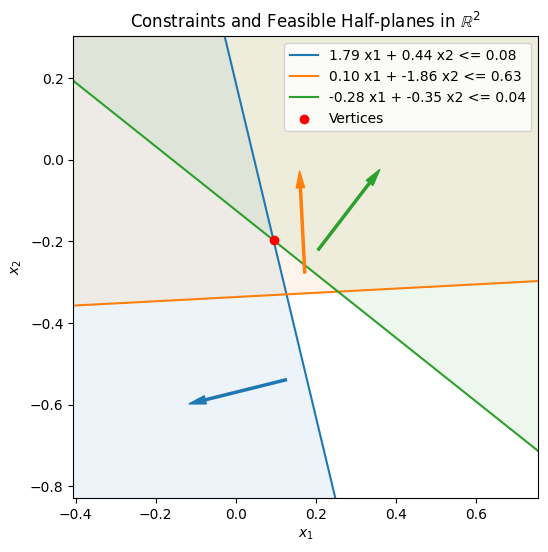

Region q: (0, 0, 1), s: [ 1  1 -1], feasible: True
A:
[[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [ 0.2773882   0.35475898]]
C:
[[ 0.08274148]
 [ 0.62700068]
 [-0.04381817]]
Vertices:
[[ 0.0944209  -0.19734359]
 [ 0.1267711  -0.32990072]]


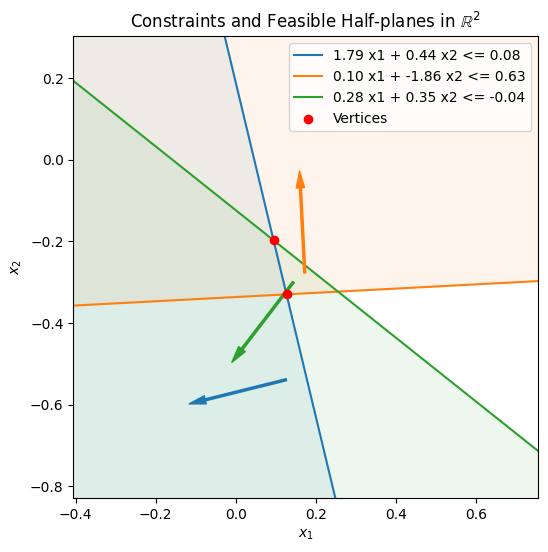

Region q: (0, 1, 1), s: [ 1 -1 -1], feasible: True
A:
[[ 1.78862847  0.43650985]
 [-0.09649747  1.8634927 ]
 [ 0.2773882   0.35475898]]
C:
[[ 0.08274148]
 [-0.62700068]
 [-0.04381817]]
Vertices:
[[ 0.1267711  -0.32990072]]


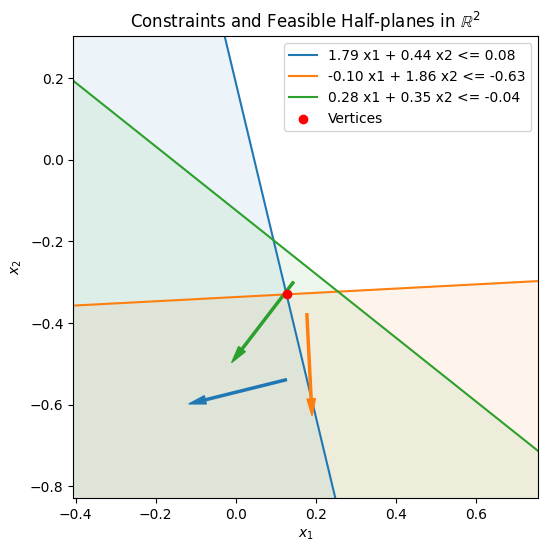

Region q: (1, 0, 0), s: [-1  1  1], feasible: True
A:
[[-1.78862847 -0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]]
C:
[[-0.08274148]
 [ 0.62700068]
 [ 0.04381817]]
Vertices:
[[ 0.0944209  -0.19734359]
 [ 0.25543093 -0.32323831]]


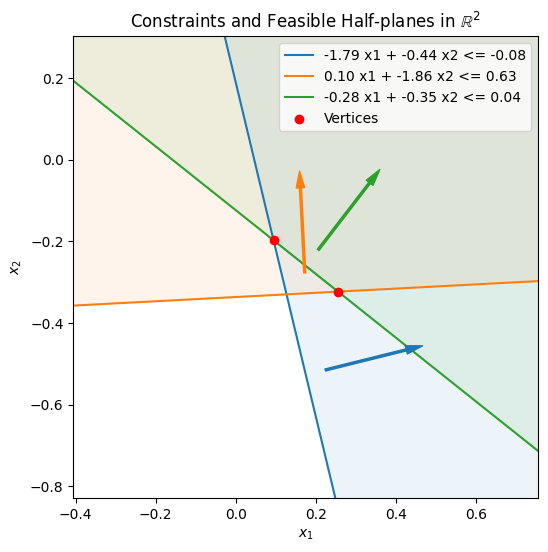

Region q: (1, 0, 1), s: [-1  1 -1], feasible: True
A:
[[-1.78862847 -0.43650985]
 [ 0.09649747 -1.8634927 ]
 [ 0.2773882   0.35475898]]
C:
[[-0.08274148]
 [ 0.62700068]
 [-0.04381817]]
Vertices:
[[ 0.0944209  -0.19734359]
 [ 0.1267711  -0.32990072]
 [ 0.25543093 -0.32323831]]


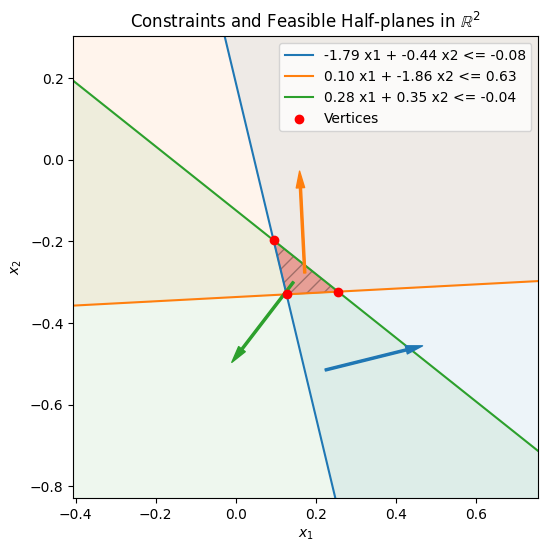

Region q: (1, 1, 0), s: [-1 -1  1], feasible: True
A:
[[-1.78862847 -0.43650985]
 [-0.09649747  1.8634927 ]
 [-0.2773882  -0.35475898]]
C:
[[-0.08274148]
 [-0.62700068]
 [ 0.04381817]]
Vertices:
[[ 0.25543093 -0.32323831]]


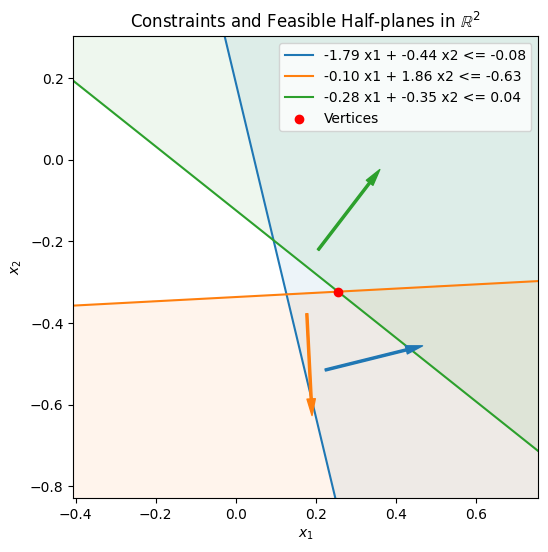

Region q: (1, 1, 1), s: [-1 -1 -1], feasible: True
A:
[[-1.78862847 -0.43650985]
 [-0.09649747  1.8634927 ]
 [ 0.2773882   0.35475898]]
C:
[[-0.08274148]
 [-0.62700068]
 [-0.04381817]]
Vertices:
[[ 0.1267711  -0.32990072]
 [ 0.25543093 -0.32323831]]


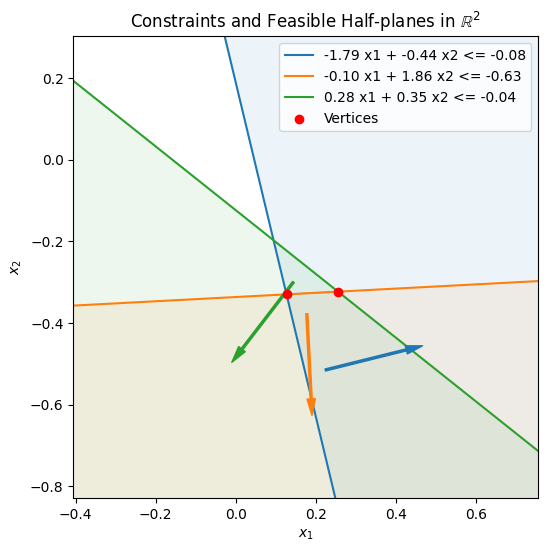

In [384]:
for region in feasible_regions:
    print(f"Region q: {region.q}, s: {region.s}, feasible: {region.feasible}")
    print(f"A:\n{region.A}")
    print(f"C:\n{region.c}")
    # print vertices
    print(f"Vertices:\n{region.V_representation}")
    plot_region(region)
    # plot_constraints_with_halfplanes(region)

## Multiple Layers

### Recursive weight matrices

They propose a recursive weight matrices and bias vectors for layer $l$: 

\begin{equation*}
    \hat{W}_l = W_l\text{diag}(q_{l-1})\hat{W}_{l-1}
\end{equation*}

and

\begin{equation}
    \hat{b}_l = W_l\text{diag}(q_{l-1})\hat{b}_{l-1}
\end{equation}
for $2\leq l \leq L$ and $\hat{W}_1=W_1$ and $\hat{b}_1 = b_1$

## Convex regions (polytopes/polyhedra)

The central idea is that points that share the same gradient $q$ belong to the same convex regions. We therefore define a convex polytope $\mathcal{P}$ in $\mathbb{R}^2$ (input space) as the set $\{ x'| q(x') = q(x) \forall x'\in\mathbb{R}^2 \}$